In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import tqdm
import torch
import random
import math

from tqdm import tqdm
import numpy as np
from PIL import Image

import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from PIL import Image
import PIL.ImageFilter as ImageFilter

mpl.rcParams['figure.figsize'] = [10.0, 10.0]

In [3]:
from coordconv import *
from utilities import flatten, unflatten, nan_canary, view
from image_dataset import ImageListDataset
from single_dot_dataset import CoordConvTranspose2d

In [4]:
class WMEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CoordConv2d(3, 32, 4, stride=2)
        self.conv2 = CoordConv2d(32, 64, 4, stride=2)
        self.conv3 = CoordConv2d(64, 128, 4, stride=2)
        self.conv4 = CoordConv2d(128, 256, 4, stride=2)  # 2x2x256

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.layer_norm(x, x.size()[1:])
#         print(x.shape)
        nan_canary(x)
        x = F.relu(self.conv2(x))
#         print(x.shape)
        nan_canary(x)
        x = F.layer_norm(x, x.size()[1:])
#         print(x.shape)
        nan_canary(x)
        x = F.relu(self.conv3(x))
#         print(x.shape)
        x = F.layer_norm(x, x.size()[1:])
#         print(x.shape)
        nan_canary(x)
        x = F.relu(self.conv4(x))
#         print(x.shape)
        x = F.layer_norm(x, x.size()[1:])
        nan_canary(x)
#         print(x.shape)
        return x

In [5]:
class WMDecoder(nn.Module):
    def __init__(self):
        super().__init__()
#         self.deconv1 = CoordConvTranspose2d(1024, 128, 5, stride=2)
        self.deconv1 = CoordConvTranspose2d(1024, 128, 5, stride=2)
        self.deconv2 = CoordConvTranspose2d(128, 64, 5, stride=2)
        self.deconv3 = CoordConvTranspose2d(64, 32, 6, stride=2)
        self.deconv4 = CoordConvTranspose2d(32, 16, 6, stride=2)
        self.to_rgb = CoordConv2d(16, 3, 1, stride=1)


    def forward(self, x):
        nan_canary(x)
#         print(x.shape)
        x = F.layer_norm(x, x.size()[1:])
#         print(x.shape)
        nan_canary(x)
        x = self.deconv1(x)
        nan_canary(x)
        x = F.relu(x)
#         print(x.shape)
        nan_canary(x)
        x = F.relu(self.deconv2(F.layer_norm(x, x.size()[1:])))
#         print(x.shape)
        nan_canary(x)
        x = F.relu(self.deconv3(F.layer_norm(x, x.size()[1:])))
#         print(x.shape)
        nan_canary(x)
        x = F.layer_norm(x, x.size()[1:])    
        x = F.relu(self.deconv4(x))  # activation and norm removed so it's a fully linear layer
        x = self.to_rgb(x)
        return x

In [6]:
class WMLatent(nn.Module):
    def __init__(self):
        super().__init__()
        self.compress = nn.Linear(1024, 128)
        self.decompress = nn.Linear(128, 1024)
    
    def forward(self, x):
        x = flatten(x)
        x = self.compress(x)
        nan_canary(x)
        latent = x
        x = self.decompress(x)
        x = unflatten(x)
        return x, latent

In [7]:
class WMAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = WMEncoder()
        self.latent = WMLatent()
        self.decoder = WMDecoder()
    
    def forward(self, x):
        x = self.encoder(x)
#         print(x.shape)
        x, latent = self.latent(x)
        x = self.decoder(x)
        return x, latent
    
    def loss(self, inputs, outputs, latents):
        return F.mse_loss(inputs, outputs)

In [8]:
# BATCH_SIZE = 512
# BATCH_SIZE = 256
# BATCH_SIZE = 128
BATCH_SIZE = 32
# BATCH_SIZE = 8
LEARNING_RATE = 0.0001
EPOCHS = 30
MOMENTUM = 0.9
# IN_POWER = 8
# IN_POWER = 6
in_dim = 64

In [9]:
mean = (0.5, 0.5, 0.5)
stddev = (0.5, 0.5, 0.5)

net_transform = transforms.Compose([
    transforms.Resize(in_dim),
    transforms.RandomCrop(in_dim, pad_if_needed=True),
    transforms.ToTensor(),
    transforms.Normalize(mean, stddev)
])

In [10]:
dataset = ImageListDataset("local_imagenet_items.txt", transform=net_transform)

In [11]:
trainloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=20
)

train_batches = math.ceil(len(dataset) / BATCH_SIZE)

In [17]:
model = WMAutoencoder().cuda()

In [18]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
def train_batch(inputs, model, optimizer):
    # get the inputs
    inputs = inputs.cuda()

    if torch.isnan(inputs).any():
        print("There's a NaN input!")
        return None

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, latents = model(inputs)
    
    if torch.isnan(outputs).any():
        print("There's a NaN output!")
        return None
    loss = model.loss(inputs, outputs, latents)
    loss.backward()
    optimizer.step()
    return loss

In [20]:
running_loss = 0
loss_steps = 5
epoch = 0

with tqdm(enumerate(trainloader, 0), total=train_batches, unit="batch") as t:
    for i, data in t:
        # get the inputs
        print(i)
        loss = train_batch(data, model, optimizer)
        

        if loss is None or torch.isnan(loss).any():
            print("There's a NaN loss!")
            break

        # print statistics
        running_loss += loss.item()
        if i % loss_steps == loss_steps - 1:  # print every N mini-batches
            string = '[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / loss_steps)
            t.set_postfix_str(string)
            running_loss = 0.0

  0%|          | 0/40037 [00:00<?, ?batch/s]

0
tensor([[[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         ...,

         [[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan],
          [

  0%|          | 0/40037 [00:00<?, ?batch/s]


Exception: Found NaN!

In [280]:
def image_to_batch(image):
    return image.view(1, 3, in_dim, in_dim)

In [35]:
def image_to_batch(image):
#     image = image.transpose(-1, 0)
    return image.view(1, *image.shape)

In [36]:
image = dataset[100]

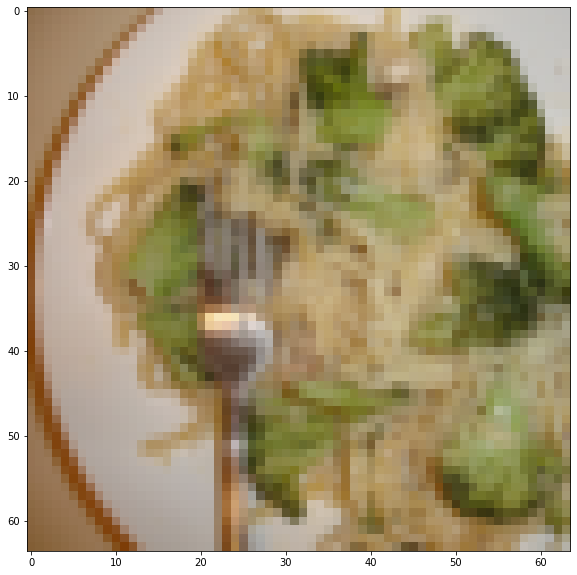

In [37]:
view(image)

In [38]:
output, latent = model(image_to_batch(image))

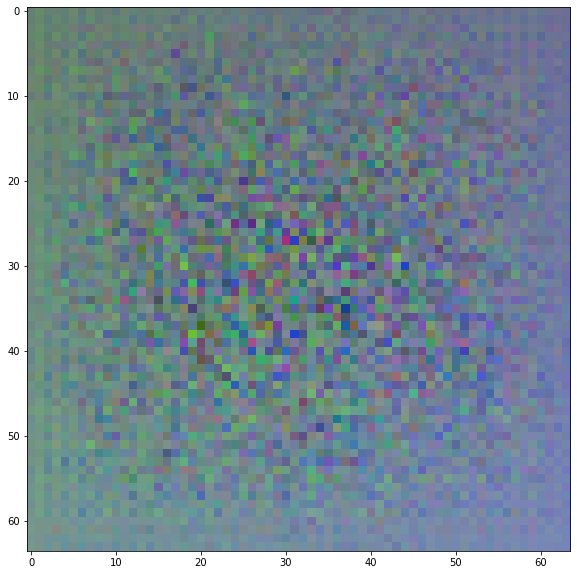

In [39]:
view(output[0])

In [291]:
def train_epoch(trainloader, train_batches, model, optimizer):
    running_loss = 0.0
    epoch = 0.0
    with tqdm(enumerate(trainloader, 0), total=train_batches, unit="batch") as t:
        for i, data in t:
            # get the inputs
            loss = train_batch(data, model, optimizer)


            if loss is None or torch.isnan(loss).any():
                print("There's a NaN loss!")
                break

            # print statistics
            running_loss += loss.item()
            if i % loss_steps == loss_steps - 1:  # print every N mini-batches
                string = '[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / loss_steps)
                t.set_postfix_str(string)
                running_loss = 0.0

In [292]:
for i in range(5):
    train_epoch(trainloader, train_batches, model, optimizer)
    

 84%|████████▍ | 33778/40037 [14:48<02:44, 37.95batch/s, [1, 33775] loss: 0.03345012]/home/benjamin/.pyenv/versions/3.7.6/envs/datasci/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 91%|█████████ | 36365/40037 [15:48<01:33, 39.41batch/s, [1, 36365] loss: 0.03066947]/home/benjamin/.pyenv/versions/3.7.6/envs/datasci/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 46%|████▋     | 18550/40037 [08:03<09:08, 39.16batch/s, [1, 18550] loss: 0.03285464]/home/benjamin/.pyenv/versions/3.7.6/envs/datasci/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 98%|█████████▊| 39097/40037 [17:01<00:23, 40.22batch/s, [1, 39100] loss: 0.02999829]/home/benjamin/.pyenv/versions/3.7.6

In [299]:
torch.save(model.state_dict(), "wmae.mod")